## XGBoost Model on Diff Data
USA World Series Results,
Run on "Diff" data

# @To Do

- [ ] Look at scaling or normalizing data
- [ ] Look at Neural Networks
- [ ] Resolve issue of target being numeric or string label
- [ ] Explore relationship between Posession Time + Attacking Rucks + Passes

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [55]:
#Import Data - only want USA matches
df = pd.read_csv("../data/output/new_features_diffdata.csv")
df.head()

,Opp,Tournament,Poss_Time_Diff,Score_Diff,Conv_Diff,Tries_Diff,Passes_Diff,Contestable_KO_Win_pct_Diff,PenFK_Against_Diff,RuckMaul_Diff,...,-99 : -75,-74 : -25,-24 : -1,0 : 25,26 : 50,51 : 75,76 : 100,101 : 125,126 : 150,Result
0,AUSTRALIA,2015_Cape_Town,13.966480,-10.638298,-14.285714,0.250000,25.925926,-50.000000,0.000000,0.000000,...,0.0,-12.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,WALES,2015_Cape_Town,7.471264,15.555556,14.285714,0.083333,27.868852,25.000000,-20.000000,-100.000000,...,0.0,0.0,0.0,12.5,0.0,0.0,0.0,0.0,0.0,1
2,KENYA,2015_Cape_Town,-33.136095,-44.444444,-33.333333,-0.750000,-10.638298,-16.666667,66.666667,60.000000,...,0.0,0.0,-5.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,NEW ZEALAND,2015_Cape_Town,51.758794,33.333333,33.333333,0.000000,76.119403,-75.000000,-50.000000,-100.000000,...,-37.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,FIJI,2015_Cape_Town,12.880562,-20.833333,-25.000000,0.266667,38.461538,-66.666667,-33.333333,-33.333333,...,0.0,-12.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [56]:
df.info()
list(df.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 27 columns):
Opp                            156 non-null object
Tournament                     156 non-null object
Poss_Time_Diff                 156 non-null float64
Score_Diff                     156 non-null float64
Conv_Diff                      156 non-null float64
Tries_Diff                     156 non-null float64
Passes_Diff                    156 non-null float64
Contestable_KO_Win_pct_Diff    156 non-null float64
PenFK_Against_Diff             156 non-null float64
RuckMaul_Diff                  156 non-null float64
Ruck_Win_pct_Diff              156 non-null float64
Cards_diff                     156 non-null float64
Lineout_Win_Pct_Diff           156 non-null float64
Scrum_Win_Pct_Diff             156 non-null float64
-175 : -150                    156 non-null float64
-149 : -125                    156 non-null float64
-124 : -100                    156 non-null float64
-99 : -75    

['Opp',
 'Tournament',
 'Poss_Time_Diff',
 'Score_Diff',
 'Conv_Diff',
 'Tries_Diff',
 'Passes_Diff',
 'Contestable_KO_Win_pct_Diff',
 'PenFK_Against_Diff',
 'RuckMaul_Diff',
 'Ruck_Win_pct_Diff',
 'Cards_diff',
 'Lineout_Win_Pct_Diff',
 'Scrum_Win_Pct_Diff',
 '-175 : -150',
 '-149 : -125',
 '-124 : -100',
 '-99 : -75',
 '-74 : -25',
 '-24 : -1',
 '0 : 25',
 '26 : 50',
 '51 : 75',
 '76 : 100',
 '101 : 125',
 '126 : 150',
 'Result']

In [57]:
from sklearn.model_selection import train_test_split

In [58]:
#Drop features that are unneccessary/str or will bias the prediction
rf_data = df.drop((['Opp', 'Score_Diff', 'Tries_Diff','Tournament', 'Conv_Diff']), axis=1)

#Drop rows with Result == "T" (Ties). This label messes up classification models
rf_data.drop(rf_data[rf_data.Result == 2].index, inplace=True)

#Pull out the variable we're trying to predict: 'Result'
X = rf_data.drop('Result',axis=1)
y = rf_data['Result']

In [59]:
rf_data.head()
#Check to insure 'Result' only contains 2 values (W, L)
rf_data['Result'].describe()
rf_data.describe()

,Poss_Time_Diff,Passes_Diff,Contestable_KO_Win_pct_Diff,PenFK_Against_Diff,RuckMaul_Diff,Ruck_Win_pct_Diff,Cards_diff,Lineout_Win_Pct_Diff,Scrum_Win_Pct_Diff,-175 : -150,...,-99 : -75,-74 : -25,-24 : -1,0 : 25,26 : 50,51 : 75,76 : 100,101 : 125,126 : 150,Result
count,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,...,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.0,151.000000,151.000000
mean,10.402130,17.196314,2.491328,-1.993963,-0.644381,0.062044,5.298013,0.124614,-0.081126,-0.496689,...,-0.745033,-3.228477,-0.331126,4.056291,5.298013,2.483444,1.324503,0.0,0.496689,0.562914
std,20.750082,26.935639,45.526240,49.889728,59.542377,0.198595,27.780280,0.668788,0.637047,6.103413,...,5.250355,5.489303,1.247514,5.871838,10.250720,9.356356,8.056095,0.0,6.103413,0.497677
min,-40.000000,-48.837209,-166.666667,-100.000000,-100.000000,-0.550000,-50.000000,-1.000000,-1.000000,-75.000000,...,-37.500000,-12.500000,-5.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,-3.491112,0.793651,-27.500000,-33.333333,-33.333333,-0.083333,0.000000,0.000000,-0.500000,0.000000,...,0.000000,-12.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
50%,11.166253,16.129032,0.000000,0.000000,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000
75%,23.795151,34.495192,33.333333,33.333333,33.333333,0.181187,0.000000,0.750000,0.000000,0.000000,...,0.000000,0.000000,0.000000,12.500000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000
max,72.272727,90.909091,133.333333,100.000000,100.000000,0.875000,100.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,12.500000,25.000000,37.500000,50.000000,0.0,75.000000,1.000000


### Set up train/test split

In [64]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.30)

## Train an XGBoost Classifier Model
Info from https://jessesw.com/XG-Boost/

In [65]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

## Set up hyperparameter tuning/Grid Search¶

In [66]:
#Set parameters for first grid search. Start tuning on the maximum depth of the trees first, 
#along with the min_child_weight, which is very similar to min_samples_split in sklearn’s version 
#of gradient boosted trees. We set the objective to ‘binary:logistic’ since this is a binary 
#classification problem
cv_params = {'max_depth': [3,5,7], 'min_child_weight': [1,3,5]}
ind_params = {'learning_rate': 0.1, 'n_estimators': 100, 'seed':101, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic'}

optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = 'accuracy', cv = 5, n_jobs = -1) 
# Optimize for accuracy

In [67]:
# Run the grid search
optimized_GBM.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=101,
       silent=True, subsample=0.8),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [68]:
# Check grid scores (see deprecation warning - change from grid_scores_ to cv_results_ attribute
optimized_GBM.grid_scores_
# score decreased from RF to 62% from 71%:
# mean: 0.62857, std: 0.13399, params: {'max_depth': 3, 'min_child_weight': 5}

/Users/admin/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.59048, std: 0.07289, params: {'max_depth': 3, 'min_child_weight': 1},
 mean: 0.55238, std: 0.06902, params: {'max_depth': 3, 'min_child_weight': 3},
 mean: 0.59048, std: 0.08564, params: {'max_depth': 3, 'min_child_weight': 5},
 mean: 0.58095, std: 0.11109, params: {'max_depth': 5, 'min_child_weight': 1},
 mean: 0.53333, std: 0.08999, params: {'max_depth': 5, 'min_child_weight': 3},
 mean: 0.59048, std: 0.08564, params: {'max_depth': 5, 'min_child_weight': 5},
 mean: 0.60952, std: 0.10249, params: {'max_depth': 7, 'min_child_weight': 1},
 mean: 0.53333, std: 0.08999, params: {'max_depth': 7, 'min_child_weight': 3},
 mean: 0.59048, std: 0.08564, params: {'max_depth': 7, 'min_child_weight': 5}]

use these parameters (resulting in mean: 0.65714):

mean: 0.60952, std: 0.10249, params: {'max_depth': 7, 'min_child_weight': 1}

** params: {'max_depth': 7, 'min_child_weight': 1} **

Adjust subsampling along with lowering the learning rate to see if that helps

In [72]:
cv_params = {'learning_rate': [0.1, 0.01], 'subsample': [0.7,0.8,0.9]}
ind_params = {'n_estimators': 100, 'seed':101, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth': 7, 'min_child_weight': 1, 'random_state': 101}


optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = 'accuracy', cv = 11, n_jobs = -1)
# Run the grid search again
optimized_GBM.fit(X_train, y_train)

GridSearchCV(cv=11, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=101, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=101, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.1, 0.01], 'subsample': [0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [73]:
# check the Grid Scores again - increased to 0.67619 by tweaking parameters
# Increased CV folds to cv=11, {'max_depth': 5, 'min_child_weight': 1}
# mean: 0.68571, std: 0.13895, params: {'learning_rate': 0.1, 'subsample': 0.8}
optimized_GBM.grid_scores_

/Users/admin/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.51429, std: 0.18013, params: {'learning_rate': 0.1, 'subsample': 0.7},
 mean: 0.52381, std: 0.16645, params: {'learning_rate': 0.1, 'subsample': 0.8},
 mean: 0.49524, std: 0.14091, params: {'learning_rate': 0.1, 'subsample': 0.9},
 mean: 0.54286, std: 0.16835, params: {'learning_rate': 0.01, 'subsample': 0.7},
 mean: 0.52381, std: 0.14294, params: {'learning_rate': 0.01, 'subsample': 0.8},
 mean: 0.52381, std: 0.15514, params: {'learning_rate': 0.01, 'subsample': 0.9}]

### Final parameters:
Got to 69% (mean: 0.54286, std: 0.16835) with **cv=11** andthe parameters below:

**params: {'learning_rate': 0.01, 'subsample': 0.7, 'max_depth': 7, 'min_child_weight': 1}**

ind_params = {'n_estimators': 100, 'seed':101, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth': 5, 'min_child_weight': 1}

## Create a DMatrix
To increase the performance of XGBoost's speed through many iterations of the training set, and since we are using only XGBoost's API and not sklearn's anymore, we can create a DMatrix. This sorts the data initially to optimize for XGBoost when it builds trees, making the algorithm more efficient. This is especially helpful when you have a very large number of training examples. To create a DMatrix:

In [74]:
# Won't work because labels are not 0,1
# Create our DMatrix to make XGBoost more efficient
xgdmat = xgb.DMatrix(X_train, y_train) 

## Early Stopping CV

In [77]:
our_params = {'eta': 0.1, 'seed':101, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':1, 'min_child_weight':1} 
# Grid Search CV optimized settings

cv_xgb = xgb.cv(params = our_params, dtrain = xgdmat, num_boost_round = 3000, nfold = 5,
                metrics = ['error'], # Make sure you enter metrics inside a list or you may encounter issues!
                early_stopping_rounds = 100) # Look for early stopping that minimizes error

In [78]:
cv_xgb.tail(5)

,test-error-mean,test-error-std,train-error-mean,train-error-std
74,0.380952,0.116643,0.226191,0.019920
75,0.380952,0.116643,0.233333,0.024513
76,0.371428,0.114286,0.233333,0.025644
77,0.361905,0.098054,0.223809,0.021822
78,0.352381,0.098054,0.219048,0.022080


### Results
Test error mean of 0.352381	, or 65% accuracy

Now that we have our best settings, let’s create this as an XGBoost object model that we can reference later.

In [80]:
our_params = {'eta': 0.1, 'seed':101, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':7, 'min_child_weight':1} 

final_gb = xgb.train(our_params, xgdmat, num_boost_round = 8)

In [82]:
# Plot feature importances
%matplotlib inline
sns.set(font_scale = 1.5)

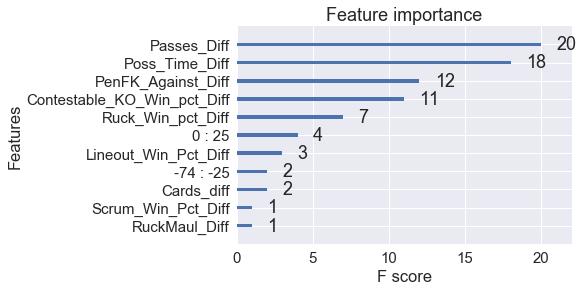

In [83]:
xgb.plot_importance(final_gb)

In [84]:
importances = final_gb.get_fscore()
importances

{'-74 : -25': 2,
 '0 : 25': 4,
 'Cards_diff': 2,
 'Contestable_KO_Win_pct_Diff': 11,
 'Lineout_Win_Pct_Diff': 3,
 'Passes_Diff': 20,
 'PenFK_Against_Diff': 12,
 'Poss_Time_Diff': 18,
 'RuckMaul_Diff': 1,
 'Ruck_Win_pct_Diff': 7,
 'Scrum_Win_Pct_Diff': 1}

In [85]:
testdmat = xgb.DMatrix(X_test, y_test)

In [86]:
from sklearn.metrics import accuracy_score
y_pred = final_gb.predict(testdmat) # Predict using our testdmat
y_pred

array([ 0.57294172,  0.51255488,  0.42118236,  0.59136558,  0.66500306,
        0.60923994,  0.37115774,  0.61581272,  0.31352291,  0.55775303,
        0.44547084,  0.36229333,  0.42599061,  0.52098423,  0.70793825,
        0.41966236,  0.40273774,  0.67804617,  0.52092099,  0.6270225 ,
        0.52419794,  0.57192278,  0.58798057,  0.68062645,  0.56759655,
        0.5257026 ,  0.54509747,  0.51280487,  0.52037197,  0.67186308,
        0.49729601,  0.32237437,  0.52965665,  0.45925316,  0.69820273,
        0.66146111,  0.41245195,  0.28498021,  0.45783597,  0.58471107,
        0.61605269,  0.41218504,  0.59331626,  0.58798057,  0.47978923,
        0.47620121], dtype=float32)

In [87]:
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0
y_pred

array([ 1.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,
        1.,  1.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,
        1.,  1.,  0.,  1.,  1.,  0.,  0.], dtype=float32)

In [88]:
accuracy_score(y_pred, y_test), 1-accuracy_score(y_pred, y_test)

(0.80434782608695654, 0.19565217391304346)

**Accuracy is 80%**